# Calculate distances between specific residues in pdb files

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
from os.path import exists
from biopandas.pdb import PandasPdb

def sanitize_protein(protein_id):
    "Replace / in protein ID with _ for compatibility with file system"
    return protein_id.replace("/", "_")

def calculate_dist(pdb, XL):
    "Calculate the distance between residues in the PDB based on the crosslink"
    # Find the C atom for each residue
    res_1 = pdb.loc[pdb['residue_number'] == XL.Res1]
    res_2 = pdb.loc[pdb['residue_number'] == XL.Res2]
    
    res_1_coords = res_1[['x_coord', 'y_coord', 'z_coord']].to_numpy()
    res_2_coords = res_2[['x_coord', 'y_coord', 'z_coord']].to_numpy()
    
    return np.linalg.norm(res_1_coords - res_2_coords)

In [2]:
# Read in XL csv file to pandas DF
XLs = pd.read_csv("Union_XL1_XL2_PurifiedSECa-g_IEXcilia2inject2.3-newpeptidepos.csv", encoding= 'unicode_escape')

# Save all intramolecular crosslinks to a new DF
XLs_intra = XLs.loc[XLs['Protein1'] == XLs['Protein2']]

# Calculate the XL position in the protein primary sequence
XLs_intra['Res1'] = XLs_intra['PepPos1'] + XLs_intra['LinkPos1'] - 1
XLs_intra['Res2'] = XLs_intra['PepPos2'] + XLs_intra['LinkPos2'] - 1

# Removes all XL redundancies 
XLs_intra['newRes1'] = XLs_intra[["Res1", "Res2"]].max(axis=1)
XLs_intra['newRes2'] = XLs_intra[["Res1", "Res2"]].min(axis=1)
XLs_intra_nonred = XLs_intra.drop_duplicates(subset=['Protein1', 'Protein2', 'newRes1', 'newRes2'], keep="last")

/var/folders/f3/4v7h5c853ysdm4s_5b6b2gz40000gn/T/ipykernel_17418/2994176413.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  XLs_intra['Res1'] = XLs_intra['PepPos1'] + XLs_intra['LinkPos1'] - 1
/var/folders/f3/4v7h5c853ysdm4s_5b6b2gz40000gn/T/ipykernel_17418/2994176413.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  XLs_intra['Res2'] = XLs_intra['PepPos2'] + XLs_intra['LinkPos2'] - 1
/var/folders/f3/4v7h5c853ysdm4s_5b6b2gz40000gn/T/ipykernel_17418/2994176413.py:12: SettingWithCopyWarning: 
A value is

In [3]:
# Extract XL counts
intra_XL_counts = XLs_intra_nonred['Protein1'].value_counts().reset_index().rename(columns = {'index': 'Protein1', 'Protein1': 'XL_count'})

In [4]:
def read_pdb_CA(pdb_filepath):
    ppdb = PandasPdb().read_pdb(pdb_filepath) # reads pdb into pandas df
    pdbatom = ppdb.df['ATOM'] # extracts only the atom data type from pdb
    return pdbatom[(pdbatom['atom_name']=='CA')] # selects the only the CA atoms

def get_af_XL_counts(protein_XL_counts, threshold, pdb_suffix):
    protein = protein_XL_counts['Protein1']
    
    protein_XLs = XLs_intra_nonred.loc[XLs_intra_nonred['Protein1'] == protein]
    #print(protein_XLs)
    
    pdb_filepath = 'models/' + sanitize_protein(protein) + pdb_suffix
    if (not exists(pdb_filepath)):
        #print(protein + ' PDB file not found. Skipping...')
        return None
    
    pdb_CA = read_pdb_CA(pdb_filepath)

    protein_XLs['af_distance'] = protein_XLs.apply(lambda x : calculate_dist(pdb_CA, x), axis=1)
    #print(protein_XLs)
    #print(protein_XLs[protein_XLs['af_distance'] < threshold])
    
    return protein_XLs[protein_XLs['af_distance'] < 30].count()['Id']

In [5]:
intra_XL_counts['af_XL_count'] = intra_XL_counts.apply(lambda x : get_af_XL_counts(x, 30, '-unrelaxed_model_1.pdb'), axis = 1)
intra_XL_counts[intra_XL_counts['af_XL_count'].notnull()]

,Protein1,XL_count,af_XL_count
4,PRKG1,38,36.0
5,EEF2,35,25.0
6,MRNC57,34,25.0
9,EMAP5/6-1,30,30.0
10,I7MJ59,30,15.0
...,...,...,...
120,I7LW80,8,8.0
121,I7LZI8,7,6.0
123,I7MEJ5,7,7.0
128,I7MHD4,7,7.0


## Compare Confidence and XL Agreement

In [6]:
def read_confidence(intra_XL_counts):
    protein = intra_XL_counts['Protein1']
    
    ranking_filepath = 'rankings/' + sanitize_protein(protein) + '-ranking_debug.json'
    if (not exists(ranking_filepath)):
        #print(protein + ' ranking file not found. Skipping...')
        return None
    
    with open(ranking_filepath) as ranking_file:
        ranking_debug = json.load(ranking_file)
        return ranking_debug['plddts']['model_1']

intra_XL_counts['confidence'] = intra_XL_counts.apply(lambda x : read_confidence(x), axis = 1)

In [7]:
intra_XL_counts['XL_agreement'] = intra_XL_counts['af_XL_count'] / intra_XL_counts['XL_count']
intra_XL_counts[intra_XL_counts['af_XL_count'].notnull()]

,Protein1,XL_count,af_XL_count,confidence,XL_agreement
4,PRKG1,38,36.0,78.041609,0.947368
5,EEF2,35,25.0,89.479929,0.714286
6,MRNC57,34,25.0,68.385990,0.735294
9,EMAP5/6-1,30,30.0,NaN,1.000000
10,I7MJ59,30,15.0,67.924191,0.500000
...,...,...,...,...,...
120,I7LW80,8,8.0,68.536852,1.000000
121,I7LZI8,7,6.0,97.085454,0.857143
123,I7MEJ5,7,7.0,80.420044,1.000000
128,I7MHD4,7,7.0,95.693012,1.000000


<AxesSubplot:xlabel='XL_agreement', ylabel='confidence'>

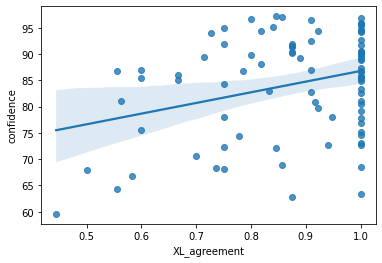

In [8]:
sns.regplot(x = intra_XL_counts['XL_agreement'], y = intra_XL_counts['confidence'])

In [9]:
# plDDT score per residue
# lower score in looped regions between domains (bc alphafold is less confident there)
# identify drops in score to try to break up domains
# Identify drops by seeing if there's a significant deviation from the moving average / deviation?
# Derivative to find an inflection point
# Calculate the plDDT average for the domain
# Figure out crosslinks within the domain, check for XL agreement in each domain
# Plot by domains instead of full protein

# Also: maybe % isn't right, maybe count the # of crosslinks that are (or are not) in agreement

# Can plot position/location vs bfactor/plDDT to see where drops are
# Can maybe steal the code for that from the Colab notebook

# Violin plot combined with swarm plot (seaborn)

## Compare Unrelaxed vs Relaxed XL counts for top 10 most crosslinked proteins

In [10]:
intra_XL_counts['af_relaxed_XL_count'] = intra_XL_counts.apply(lambda x : get_af_XL_counts(x, 30, '-relaxed_model_1.pdb'), axis = 1)
intra_XL_counts['relaxed_XL_agreement'] = intra_XL_counts['af_relaxed_XL_count'] / intra_XL_counts['XL_count']
intra_XL_counts['relaxed_vs_unrelaxed_diff'] = intra_XL_counts['af_relaxed_XL_count'] - intra_XL_counts['af_XL_count']
intra_XL_counts[intra_XL_counts['af_relaxed_XL_count'].notnull()]

,Protein1,XL_count,af_XL_count,confidence,XL_agreement,af_relaxed_XL_count,relaxed_XL_agreement,relaxed_vs_unrelaxed_diff
4,PRKG1,38,36.0,78.041609,0.947368,35.0,0.921053,-1.0
5,EEF2,35,25.0,89.479929,0.714286,25.0,0.714286,0.0
6,MRNC57,34,25.0,68.385990,0.735294,24.0,0.705882,-1.0
9,EMAP5/6-1,30,30.0,NaN,1.000000,30.0,1.000000,0.0
10,I7MJ59,30,15.0,67.924191,0.500000,17.0,0.566667,2.0
11,BBC118,25,15.0,85.481704,0.600000,15.0,0.600000,0.0
12,FTT18,25,21.0,95.138586,0.840000,21.0,0.840000,0.0
13,EARS,24,24.0,91.715565,1.000000,24.0,1.000000,0.0
14,EMAP5/6-2,22,22.0,NaN,1.000000,22.0,1.000000,0.0
16,Q23A15,20,12.0,75.527561,0.600000,14.0,0.700000,2.0


## Examine plDDT pattern in protein PRKG1 and I7MJ59 to see how to extract domains

In [11]:
pdb_CA = read_pdb_CA('models/PRKG1-relaxed_model_1.pdb')
if pdb_CA is None:
    print('PRKG1 relaxed model not found')
pdb_CA.columns

Index(['record_name', 'atom_number', 'blank_1', 'atom_name', 'alt_loc',
       'residue_name', 'blank_2', 'chain_id', 'residue_number', 'insertion',
       'blank_3', 'x_coord', 'y_coord', 'z_coord', 'occupancy', 'b_factor',
       'blank_4', 'segment_id', 'element_symbol', 'charge', 'line_idx'],
      dtype='object')

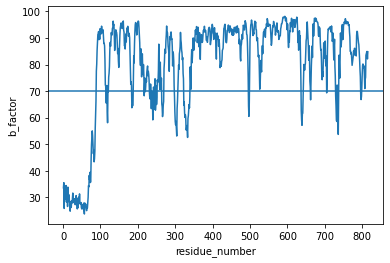

In [12]:
plddt_plot = sns.lineplot(x = pdb_CA.residue_number, y = pdb_CA.b_factor)
plddt_plot.axhline(70)
plt.show()

In [13]:
results = pd.read_pickle('results/PRKG1-result_model_1.pkl')
results

{'distogram': {'bin_edges': array([ 2.3125  ,  2.625   ,  2.9375  ,  3.25    ,  3.5625  ,  3.875   ,
          4.1875  ,  4.5     ,  4.8125  ,  5.125   ,  5.4375  ,  5.75    ,
          6.0625  ,  6.375   ,  6.6875  ,  7.      ,  7.3125  ,  7.625   ,
          7.9375  ,  8.25    ,  8.5625  ,  8.875   ,  9.1875  ,  9.5     ,
          9.812499, 10.125   , 10.4375  , 10.75    , 11.0625  , 11.375   ,
         11.6875  , 12.      , 12.3125  , 12.625   , 12.9375  , 13.25    ,
         13.5625  , 13.875   , 14.1875  , 14.499999, 14.8125  , 15.125   ,
         15.4375  , 15.75    , 16.0625  , 16.375   , 16.6875  , 16.999998,
         17.312498, 17.625   , 17.9375  , 18.25    , 18.5625  , 18.875   ,
         19.1875  , 19.5     , 19.8125  , 20.125   , 20.437498, 20.75    ,
         21.0625  , 21.375   , 21.6875  ], dtype=float32),
  'logits': array([[[ 1.43151794e+02, -4.32302713e-01, -1.71075516e+01, ...,
           -5.44000282e+01, -5.39171906e+01, -7.86112976e+01],
          [ 6.31659031e+0

In [14]:
pdb_CA = read_pdb_CA('models/I7MJ59-relaxed_model_1.pdb')
if pdb_CA is None:
    print('I7MJ59 relaxed model not found')
pdb_CA.columns

Index(['record_name', 'atom_number', 'blank_1', 'atom_name', 'alt_loc',
       'residue_name', 'blank_2', 'chain_id', 'residue_number', 'insertion',
       'blank_3', 'x_coord', 'y_coord', 'z_coord', 'occupancy', 'b_factor',
       'blank_4', 'segment_id', 'element_symbol', 'charge', 'line_idx'],
      dtype='object')

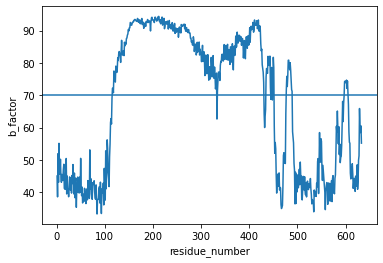

In [15]:
plddt_plot = sns.lineplot(x = pdb_CA.residue_number, y = pdb_CA.b_factor)
plddt_plot.axhline(70)
plt.show()